<center>
<h1><b>Homework 4</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 30, 2020</b></h3>
</center>
<hr>

# Problem 1
## Problem 7.2 (p.188)

Simulate a random walk in three dimensions allowing the walker to make steps of unit length in random directions; don't restrict the walker to sites on a discrete lattice. Show that the motion is diffusive, that is, $\left<r^2\right>\sim t$. Find the value of the proportionality constant.

In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from tqdm import tqdm
from scipy.spatial.distance import cdist

np.set_printoptions(sign=' ', linewidth=100, precision=4, suppress=True)
plt.style.use('dark_background')

#### Initialize the random number generator

In [2]:
rng = default_rng()

In [3]:
# define a dot product function used for the rotate operation
def v_dot(a): return lambda b: np.dot(a,b)

v_dot = lambda a : lambda b: np.dot(a,b)

class lattice_SAW:
    def __init__(self,N):
        self.N = N
        # initial configuration. Usually we just use a straight chain as inital configuration
        self.init_state = np.dstack((np.arange(N),np.zeros(N),np.zeros(N)))[0]
        self.state = self.init_state.copy()

        # define a rotation matrix
        # 9 possible rotations: 3 axes * 3 possible rotate angles(90,180,270)
        self.rotate_matrix = np.array([
            [[  1,  0,  0], [  0,  0, -1], [  0,  1,  0]],
            [[  1,  0,  0], [  0, -1,  0], [  0,  0, -1]],
            [[  1,  0,  0], [  0,  0,  1], [  0, -1,  0]],
            [[  0,  0,  1], [  0,  1,  0], [ -1,  0,  0]],
            [[ -1,  0,  0], [  0,  1,  0], [  0,  0, -1]],
            [[  0,  0, -1], [  0,  1,  0], [ -1,  0,  0]],
            [[  0, -1,  0], [  1,  0,  0], [  0,  0,  1]],
            [[ -1,  0,  0], [  0, -1,  0], [  0,  0,  1]],
            [[  0,  1,  0], [ -1,  0,  0], [  0,  0,  1]]])

    # define pivot algorithm process where t is the number of successful steps
    def walk(self,t):
        acpt = 0
        # while loop until the number of successful step up to t
        while acpt <= t:
            pick_pivot = np.random.randint(1,self.N-1) # pick a pivot site
            pick_side = np.random.choice([-1,1]) # pick a side

            if pick_side == 1:
                old_chain = self.state[0:pick_pivot+1]
                temp_chain = self.state[pick_pivot+1:]
            else:
                old_chain = self.state[pick_pivot:]
                temp_chain = self.state[0:pick_pivot]

            # pick a symmetry operator
            symtry_oprtr = self.rotate_matrix[np.random.randint(len(self.rotate_matrix))]
            # new chain after symmetry operator
            new_chain = np.apply_along_axis(v_dot(symtry_oprtr),1,temp_chain - self.state[pick_pivot]) + self.state[pick_pivot]

            # use cdist function of scipy package to calculate the pair-pair distance between old_chain and new_chain
            overlap = cdist(new_chain,old_chain)
            overlap = overlap.flatten()

            # determinte whether the new state is accepted or rejected
            if len(np.nonzero(overlap)[0]) != len(overlap):
                continue
            else:
                if pick_side == 1:
                    self.state = np.concatenate((old_chain,new_chain),axis=0)
                elif pick_side == -1:
                    self.state = np.concatenate((new_chain,old_chain),axis=0)
                acpt += 1

        # place the center of mass of the chain on the origin
        self.state = self.state - np.int_(self.state[0])
        # self.state = self.state - np.int_(np.mean(self.state,axis=0))

In [4]:
def random_walker(num_steps=1000, *args):
    theta = 2 * np.pi * rng.random(num_steps)
    phi = np.pi * rng.random(num_steps)

#     theta = 2 * np.pi * rng.standard_normal(num_steps)
#     phi = np.pi * rng.standard_normal(num_steps)
    
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    
    steps = np.vstack((x, y, z))
    positions = np.cumsum(steps, 1)
    return positions

def random_walker_diffusion(num_steps=1000, *args):
    return np.apply_along_axis(np.linalg.norm, 0, random_walker(num_steps=num_steps, *args)) ** 2

## Random Walk Path

In [5]:
num_steps = 100000
rw = random_walker(num_steps)

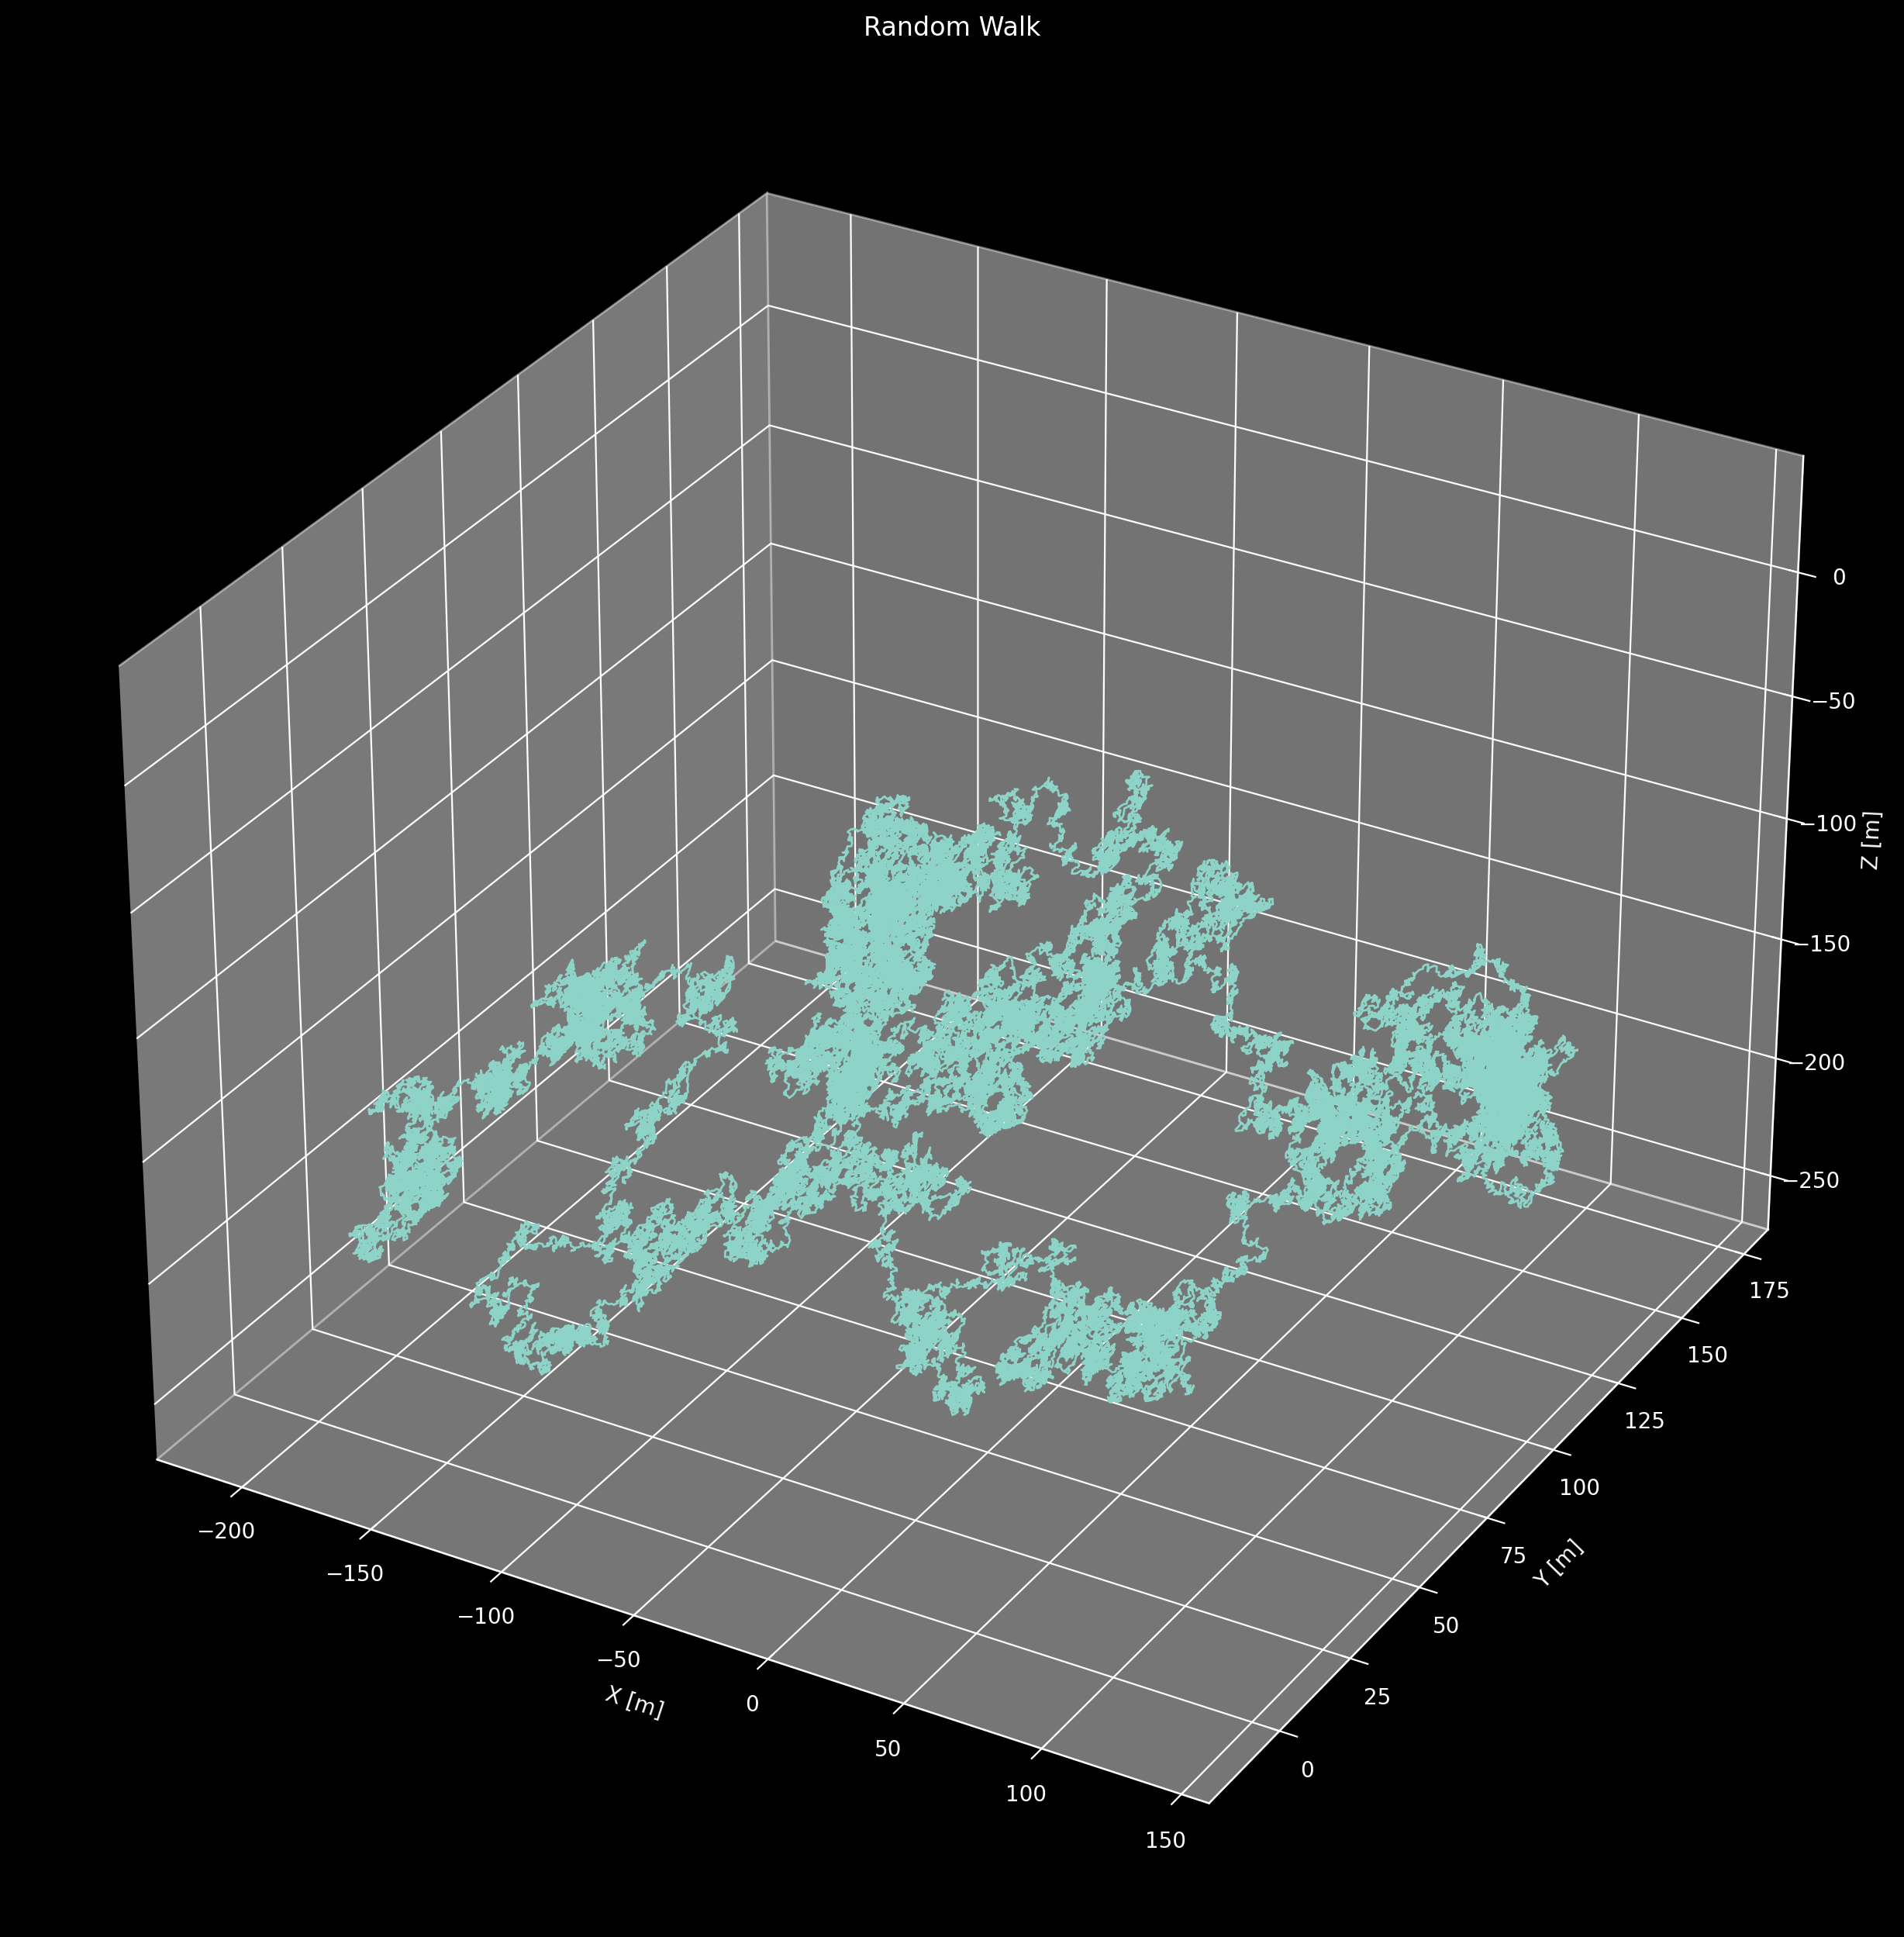

In [6]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.gca(projection="3d")
ax.set_title("Random Walk")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.plot(rw[0], rw[1], rw[2], lw=1)
plt.savefig('Problem_1a.png')

## Random Walk Diffusion

In [8]:
num_steps = 1000
num_walkers = 1000

ensemble = np.zeros((num_walkers, num_steps))
for i in tqdm(range(num_walkers)):
    ensemble[i,:] = random_walker_diffusion(num_steps=num_steps)
    
mean_square_distances = np.apply_along_axis(np.average, 0, ensemble)
fit_x = range(mean_square_distances.size)
fit = Polynomial.fit(fit_x, mean_square_distances, 1).convert()

100%|██████████| 1000/1000 [00:17<00:00, 56.48it/s]


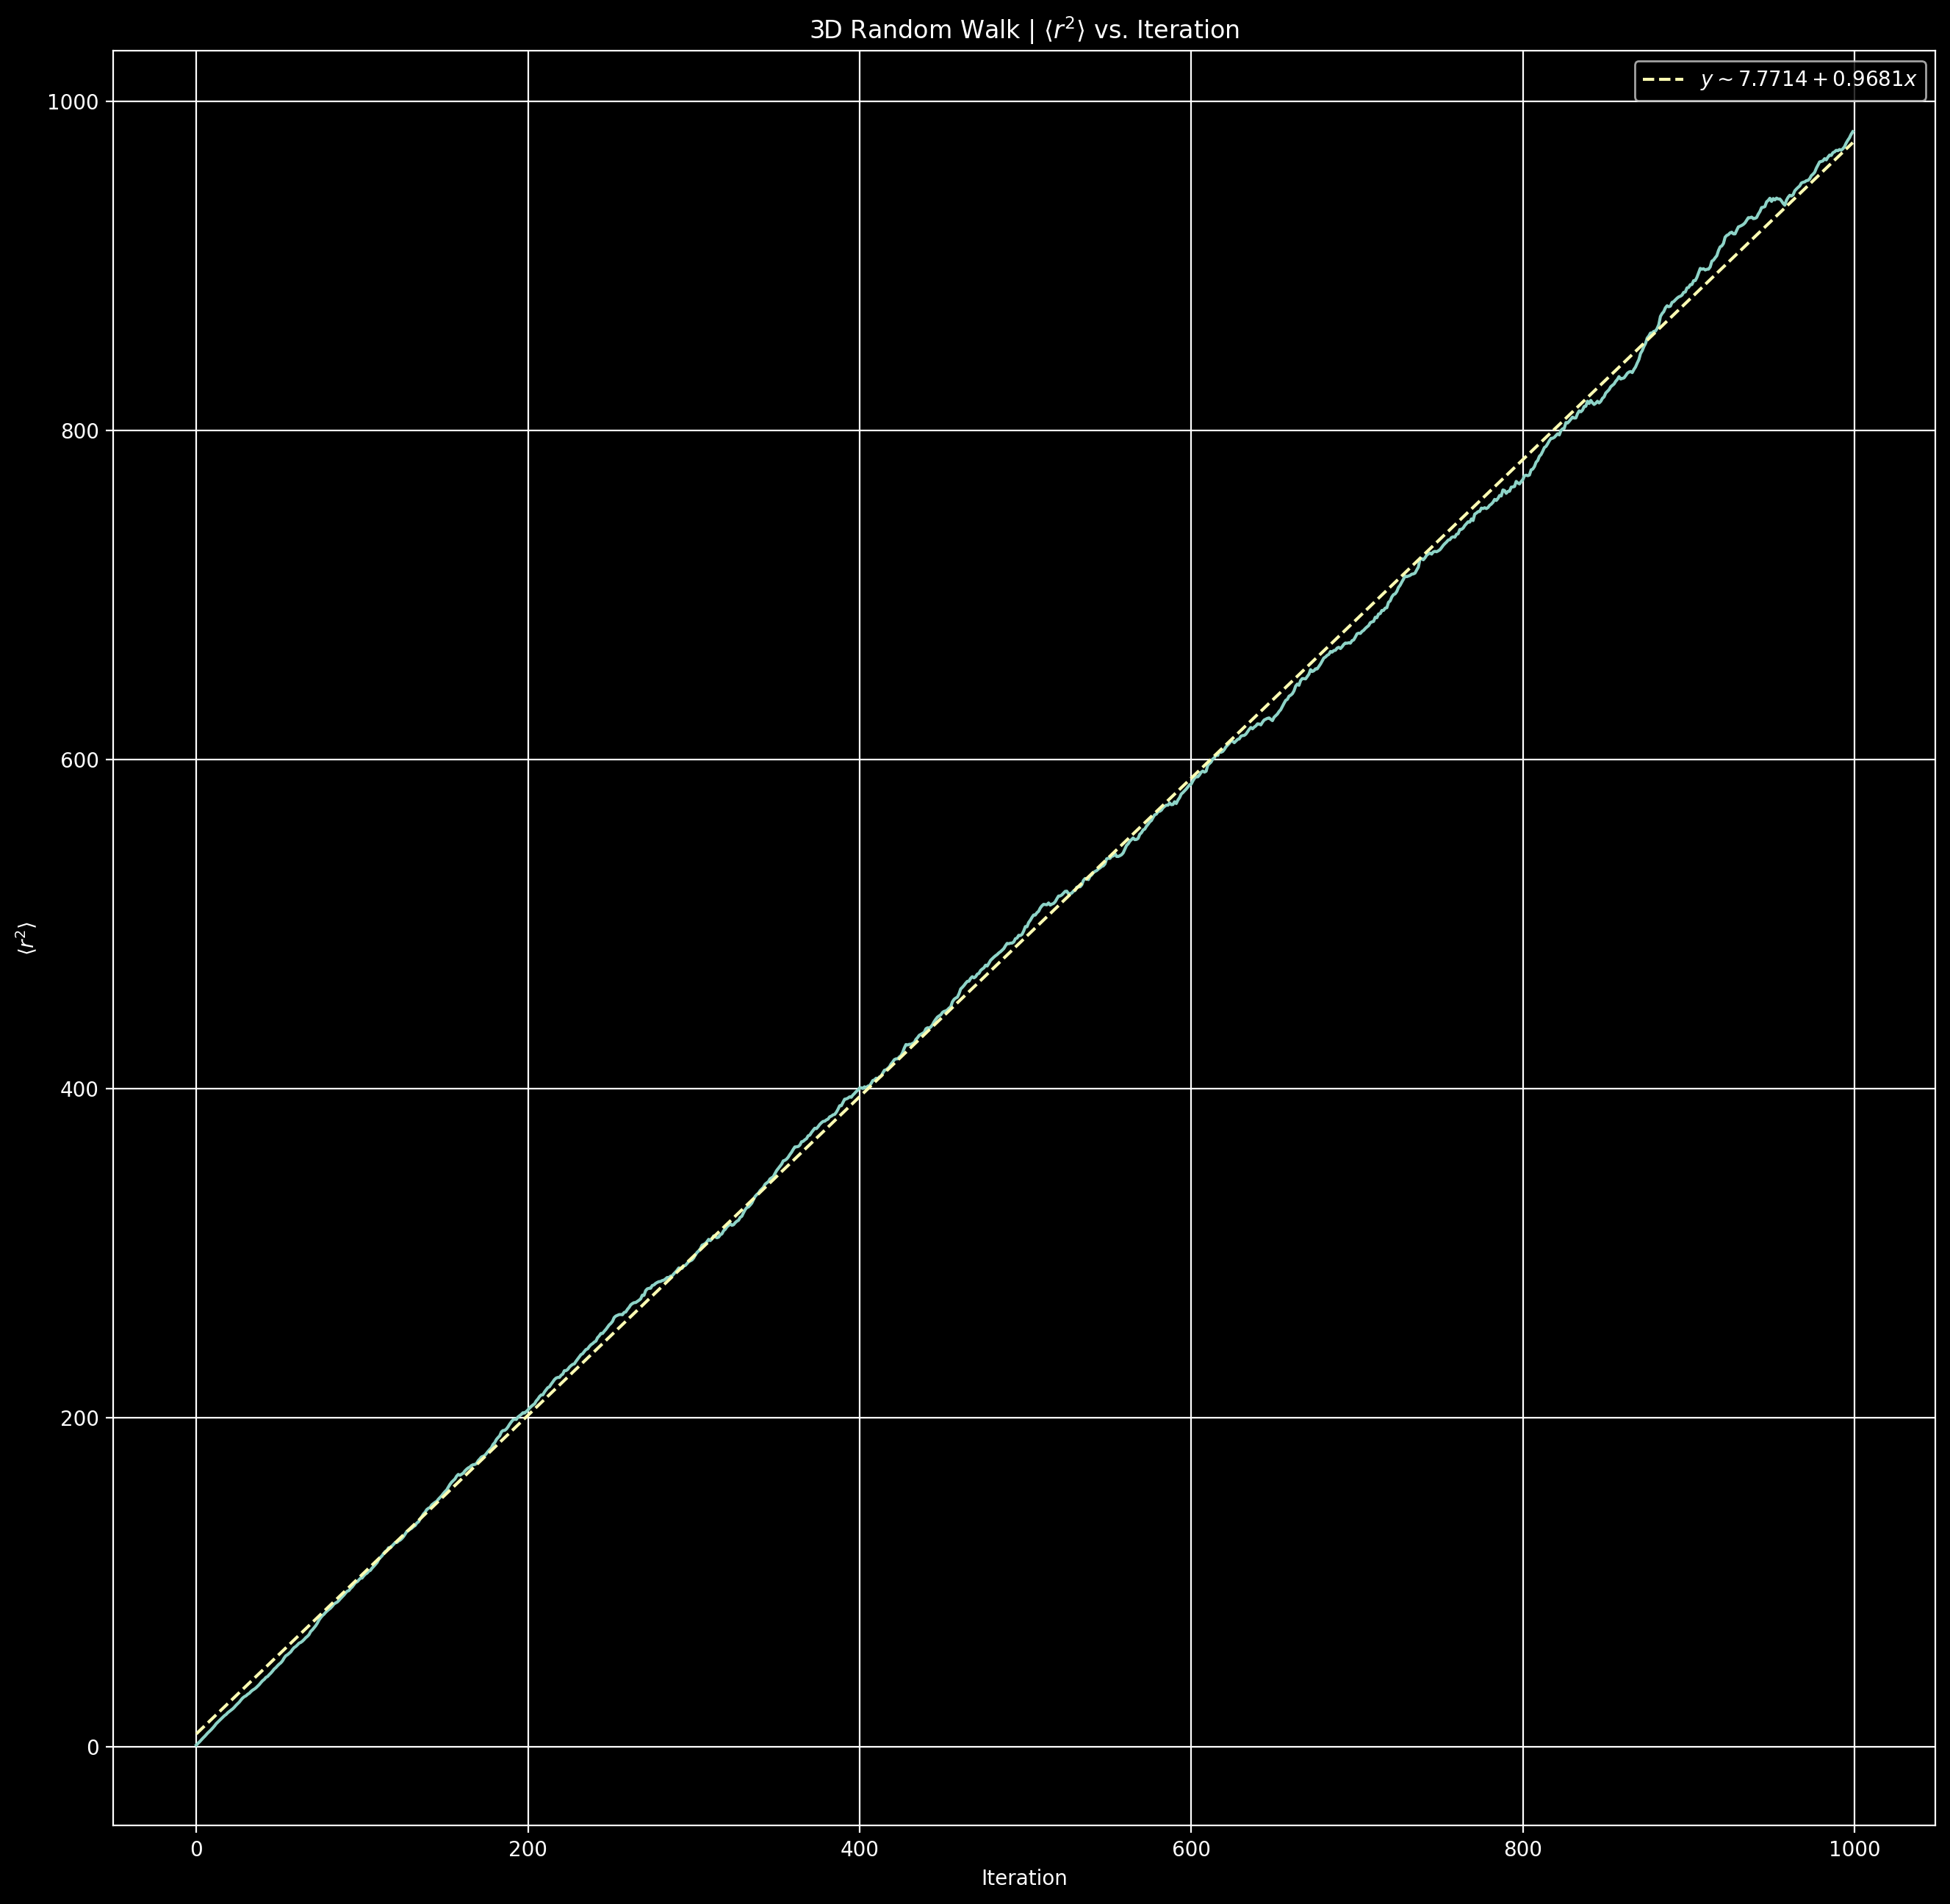

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,16), dpi=200)
ax.set_title(r'3D Random Walk | $\left<r^2\right>$ vs. Iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\left<r^2\right>$')

ax.plot(mean_square_distances)
ax.plot(fit_x, fit(fit_x), ls='--', label=fr'$y\sim{fit.coef[0]:0.4f}+{fit.coef[1]:0.4f}x$')

ax.grid()
ax.legend()
plt.savefig('Problem1b.png')

# Problem 2
## 7.6 (p.194)

Simulate SAWs in three dimensions. Determine the variation of $\left<r^2\right>$ with step number and find the value of $\nu$, where this parameter is defined through the relation (7.9). Compare your results with those in Figure 7.6. You should find that $\nu$ decreases for successively higher dimensions. (It is $1$ in one dimension and $3/4$ in two dimensions.) Can you explain this trend qualitatively?

Also check whether you can reproduce the analytic result $ν = 3/4$ for SAW on a 2D grid.

In [10]:
num_steps = 1000
t = 1000
chain = lattice_SAW(num_steps)
chain.walk(t)

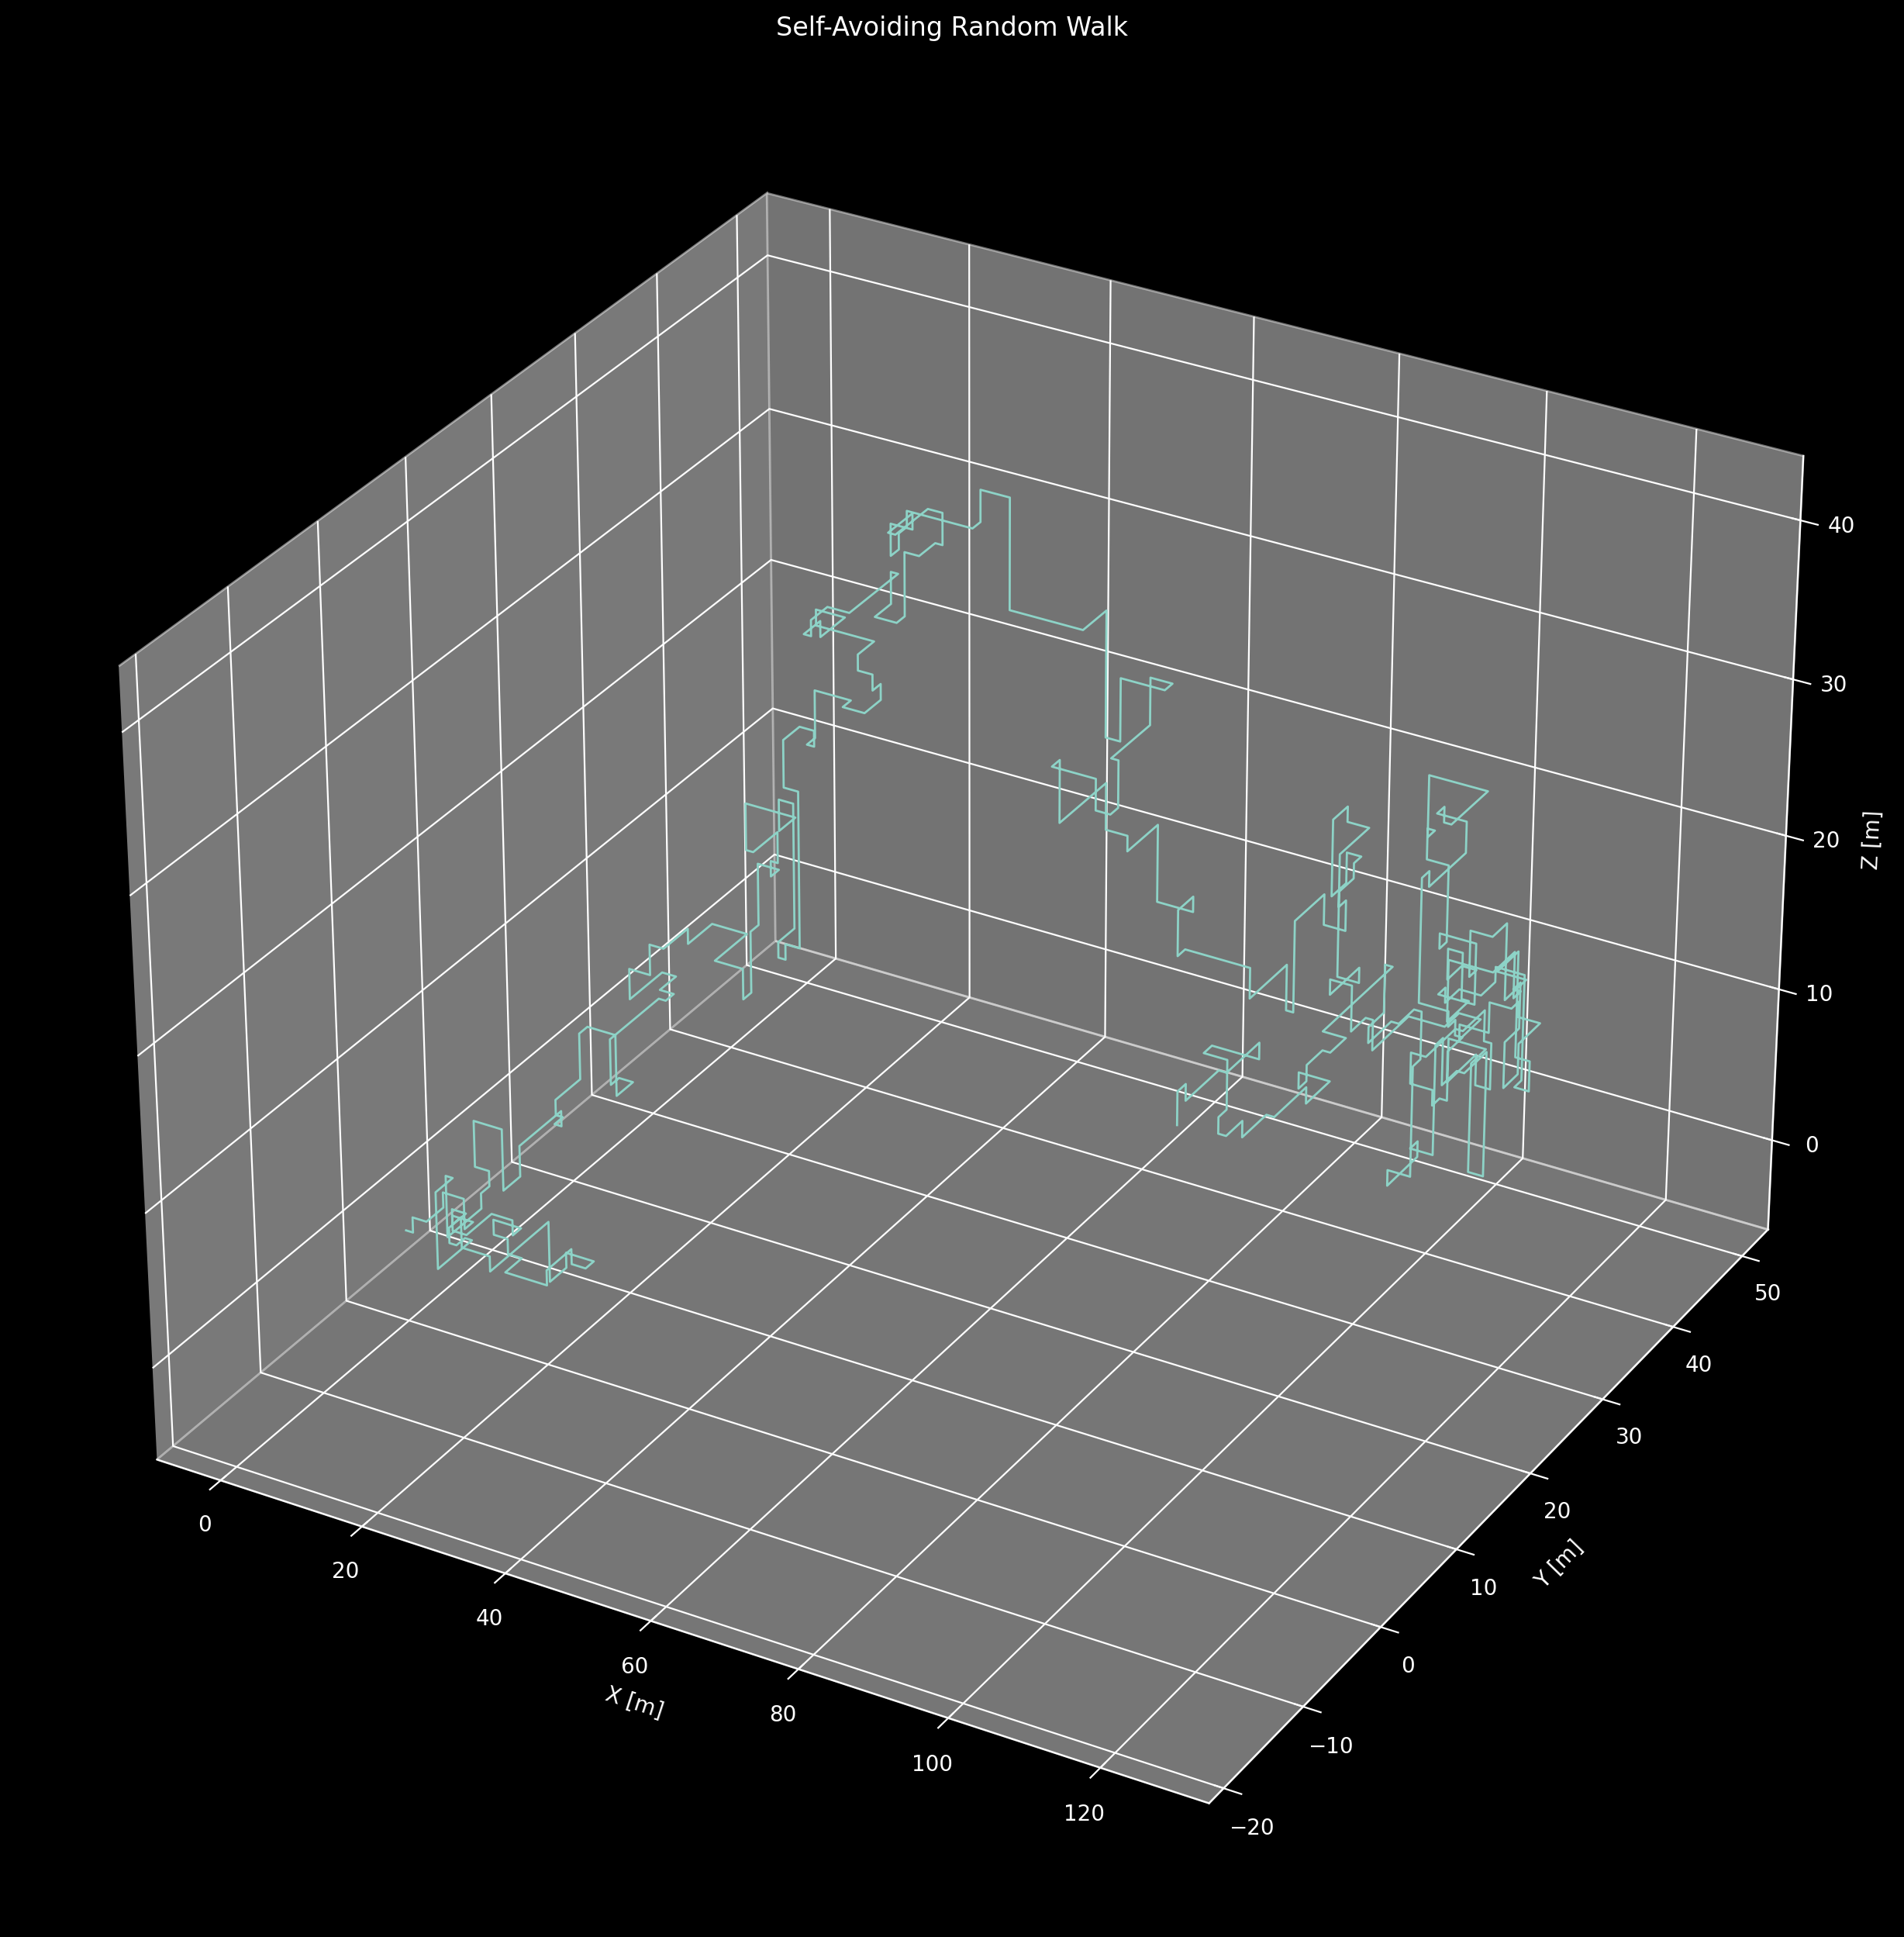

In [11]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.gca(projection="3d")
ax.set_title("Self-Avoiding Random Walk")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.plot(chain.state[:,0], chain.state[:,1],chain.state[:,2], lw=1)
plt.savefig('Problem_2a.png')

In [18]:
num_steps = 100
num_walkers = 100

chain = lattice_SAW(num_steps)
ensemble = np.zeros((num_walkers, num_steps))
for i in tqdm(range(num_walkers)):
    chain.walk(t)
    ensemble[i,:] = np.apply_along_axis(np.linalg.norm, 0, chain.state.T) ** 2

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


In [19]:
mean_square_distances = np.apply_along_axis(np.average, 0, ensemble)
fit_x = range(mean_square_distances.size)
fit = Polynomial.fit(fit_x, mean_square_distances, 1).convert()

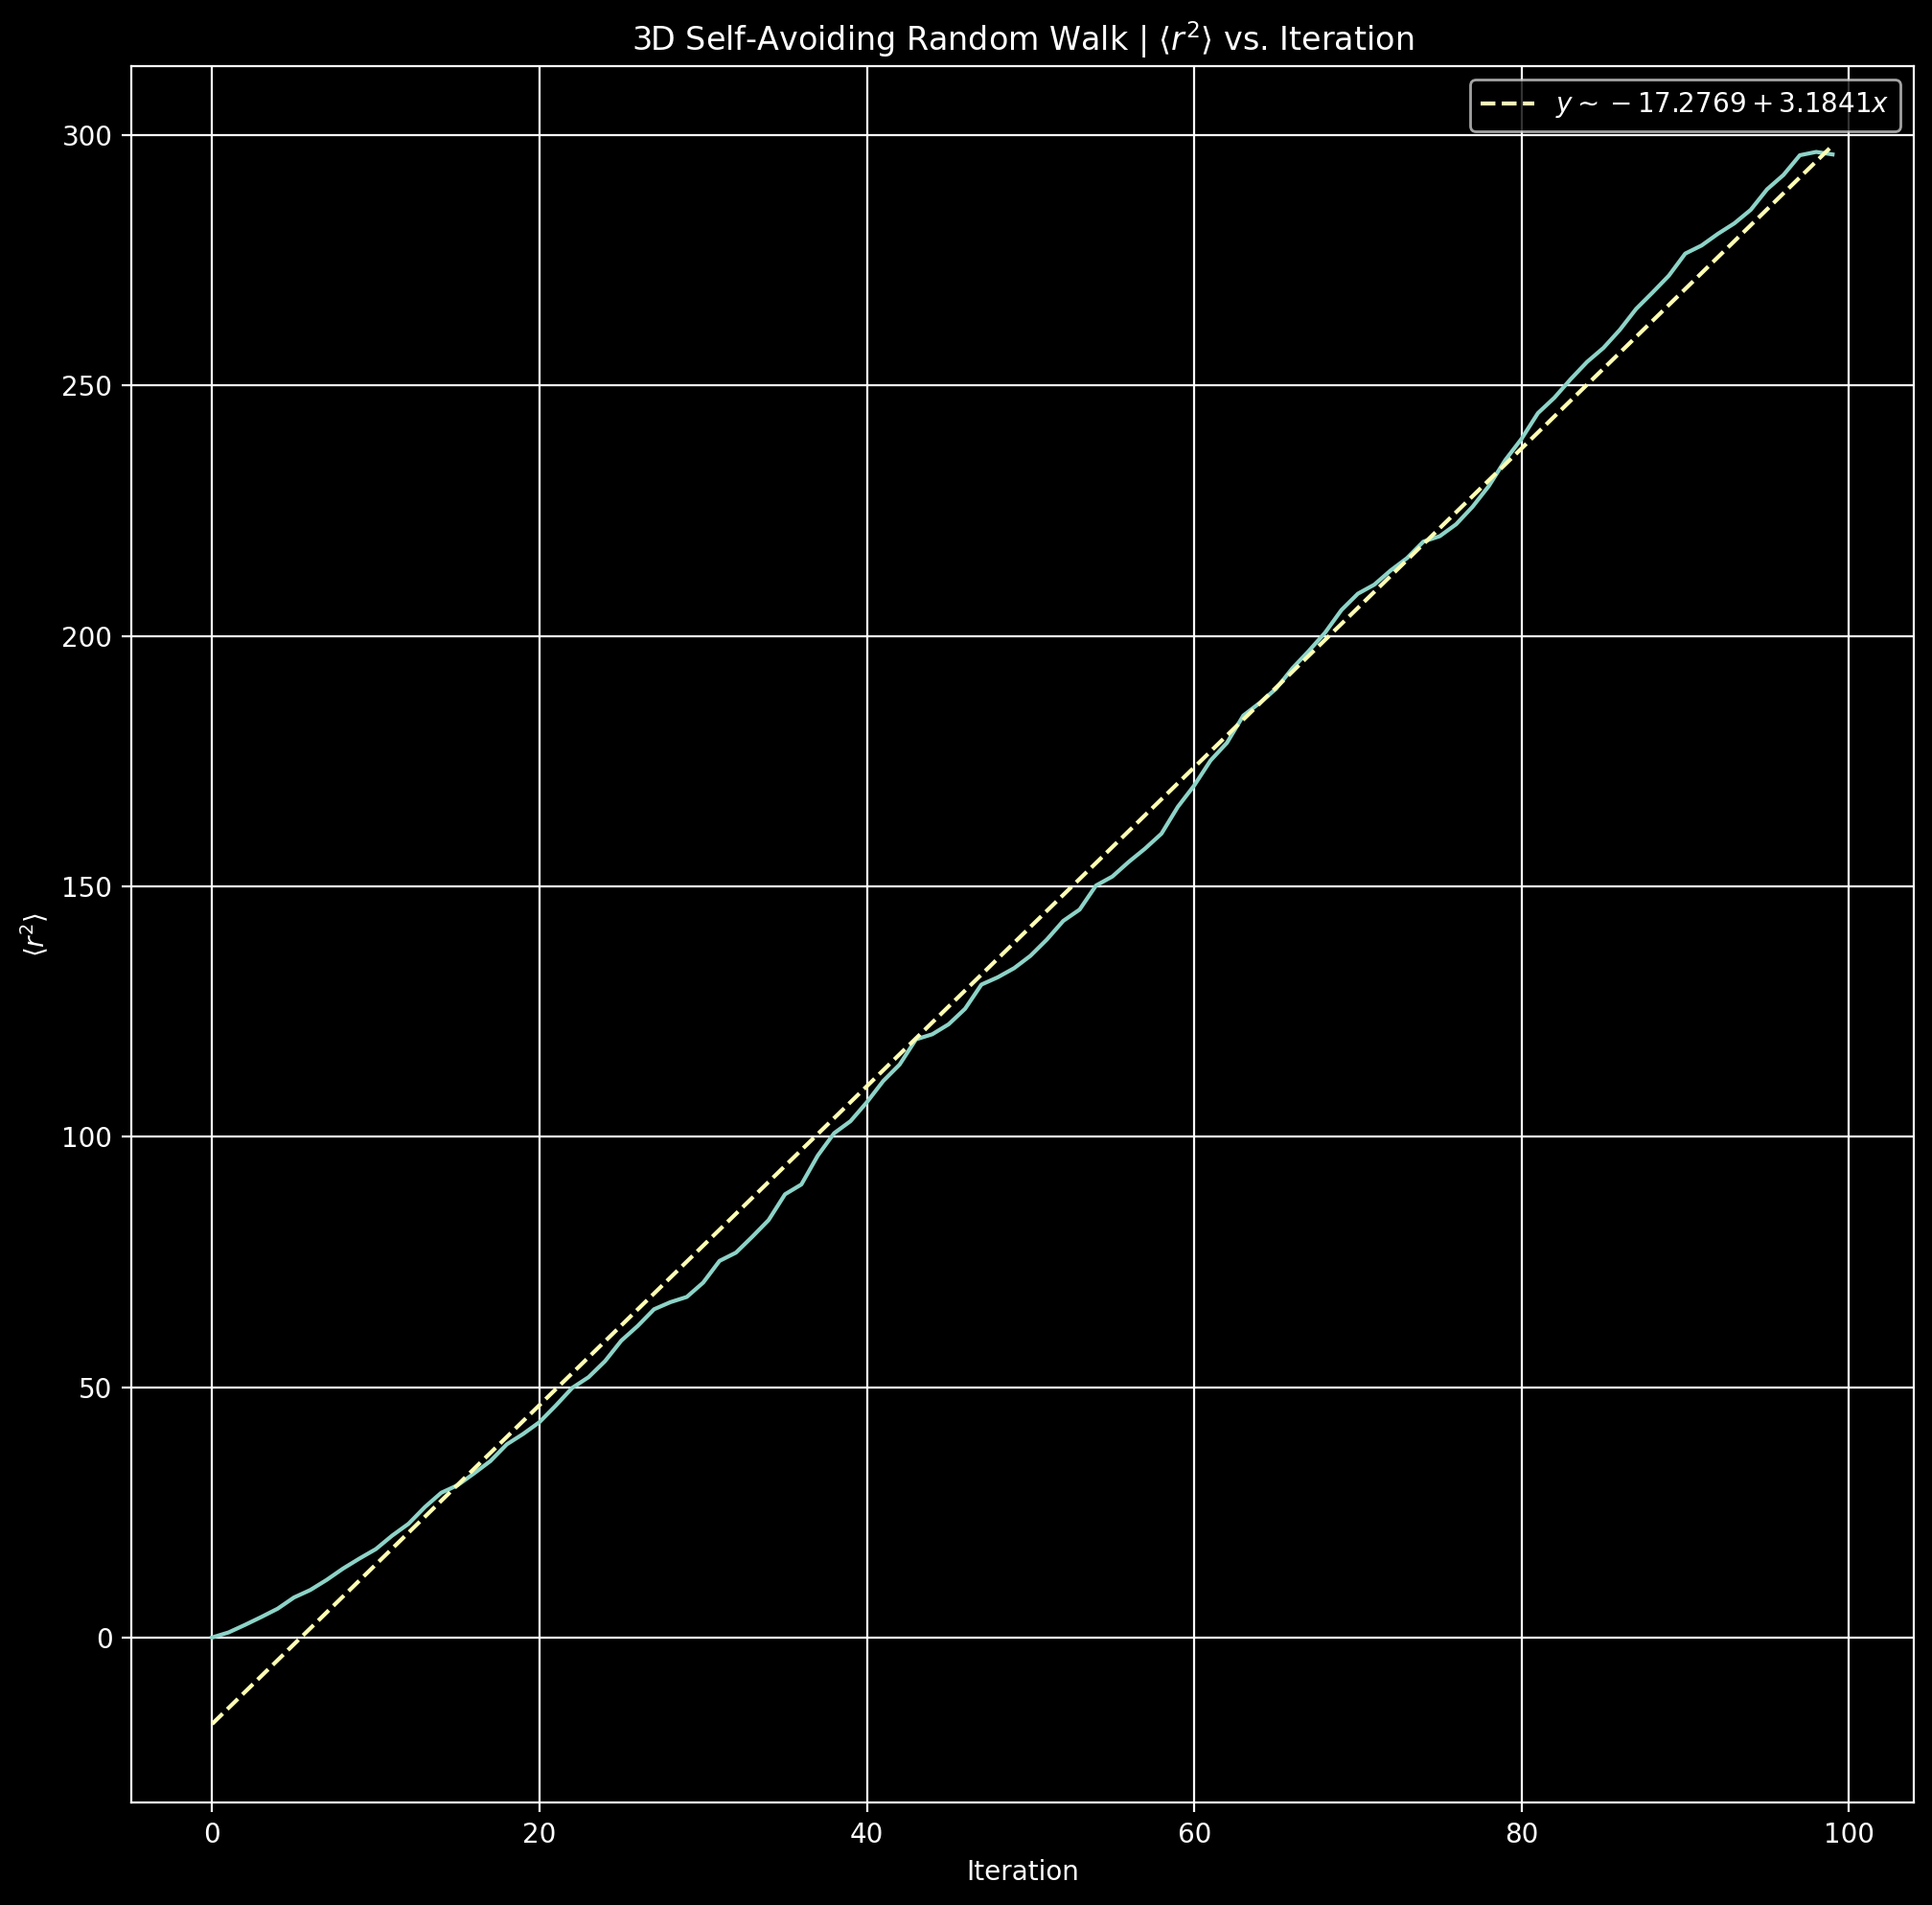

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12,12), dpi=200)
ax.set_title(r'3D Self-Avoiding Random Walk | $\left<r^2\right>$ vs. Iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\left<r^2\right>$')

ax.plot(mean_square_distances)
ax.plot(fit_x, fit(fit_x), ls='--', label=fr'$y\sim{fit.coef[0]:0.4f}+{fit.coef[1]:0.4f}x$')

ax.grid()
ax.legend()
plt.savefig('Problem2b.png')

# Problem 3
## 7.12 (p.205)

Calculate the entropy for the cream-in-your-coffee problem, and reproduce the results in Figure 7.16.

If you have trouble with running time, then try first on coarser grids (e.g., $50\times50$ for the random walk, $4\times4$ for the entropy, and only $100$ particles)

# Problem 4
## 7.15 (p.205)

Perform the random-walk simulation of spreading cream (Figures 7.13 and 7.14), and let one of the walls of the container possess a small hole so that if a cream particle enters the hole, it leaves the container. Calculate the number of particles in the container as a function of time. Show that this number, which is proportional to the partial pressure of the cream particles varies as $e^{-\frac{t}{\tau}}$, where $\tau$ is the effective time constant for the escape. _Hint:_ Reasonable parameter choices are a $50\times50$ container lattice and a hole $10$ units in length along one of the edges.